# Exercise 1: Patients Prescribed Opioids

## Learning Objectives and Key Concepts

Workshop attendees will learn how to:
* Query a FHIR Server to learn about its capabilities
* How to read FHIR specifications and understand how it applies to FHIR interactions and data
* Search for resources of various types and parse the results to find information of interest
* Process paginated responses
* Understanding FHIR Resources to find data of interest
* Exploring MedicationRequest
* Integrate other, non-FHIR based APIs

## Icons in this Guide
📘A link to a useful external reference related to the section the icon appears in

## Introduction

This notebook explores a FHIR server with a RESTful API which contains data with patients currently prescribed opioids. We'll explore the FHIR Server to learn about its capabilities, query for FHIR resources, and generate some basic visualizations from the data.

### Environment Configuration

First, let's configure the environment with the libraries and settings that will be used throughtout the rest of the exercise.

In [1]:
# Python standard library API for dealing with json
import json
# For making HTTP requests to the FHIR server
import requests
# Python data analysis library
import pandas as pd
# Jupyter utilities for displaying text and tables
from IPython.display import display
# Python standard library API for date calculations
from datetime import datetime, date

# Configure requests session with standard headers
s = requests.Session()
s.headers.update({'Accept':'application/fhir+json', 'Content-Type': 'application/fhir+json'})

# Optional: Turn off SSL verification. Useful when dealing with a corporate proxy with self-signed certificates.
s.verify = False
requests.packages.urllib3.disable_warnings()

FHIR_SERVER = 'https://api.logicahealth.org/opioids/open'

# NOTE: No cell output.

## Querying the Server

All servers are required to support the `capabilities` interaction which documents the server's functionality. The capability interaction is of the form:

`GET [base]/metadata`

📘[Read more about the capabilities interaction](https://www.hl7.org/fhir/http.html#capabilities)

In [2]:
r = s.get(f"{FHIR_SERVER}/metadata")
print(f"HTTP Status Code: {r.status_code}")
capability_statement = r.json()

HTTP Status Code: 200


The HTTP status code, `200 - OK` indicates a successful response. The CapabilityStatement is usually a very large resource so we'll focus on a few key elements. Namely, the FHIR version supported, the Resource formats supported, the number of RESTful Endpoints, and the endpoint types.

In [3]:
print(f"FHIR Version Supported: {capability_statement['fhirVersion']}")
print(f"Formats Supported: {', '.join(capability_statement['format'])}")
print()

print(f"Number of RESTful Endpoints: {len(capability_statement['rest'])}")
for rest in capability_statement['rest']:
    print(f"Endpoint Type: {rest['mode']}")

FHIR Version Supported: 4.0.1
Formats Supported: application/fhir+xml, application/fhir+json

Number of RESTful Endpoints: 1
Endpoint Type: server


There is only a single server RESTful endpoint. We can also see the types of FHIR Resources available on this endpoint and the supported operations. Keep in mind that there might not be any data available for a particular FHIR resource even if the server supports that type.

In [4]:
rest = capability_statement['rest'][0]
data = {'Resource': [resource['type'] for resource in rest['resource']],
        'Interaction': [[interaction['code'] for interaction in resource['interaction']] for resource in rest['resource']],
        'Search': [[search['name'] for search in resource['searchParam']] for resource in rest['resource']]}

capabilities_df = pd.DataFrame.from_dict(data)

print('Supported Resources')
display(capabilities_df[['Resource']])

print('Interactions Supported by Resource')
display(capabilities_df.explode('Interaction')[['Resource','Interaction']])

print('Searches Supported by Resource')
display(capabilities_df.explode('Search')[['Resource','Search']])

Supported Resources


,Resource
0,Account
1,ActivityDefinition
2,AdverseEvent
3,AllergyIntolerance
4,Appointment
...,...
141,TestReport
142,TestScript
143,ValueSet
144,VerificationResult


Interactions Supported by Resource


,Resource,Interaction
0,Account,read
0,Account,vread
0,Account,update
0,Account,patch
0,Account,delete
...,...,...
145,VisionPrescription,delete
145,VisionPrescription,history-instance
145,VisionPrescription,history-type
145,VisionPrescription,create


Searches Supported by Resource


,Resource,Search
0,Account,_language
0,Account,owner
0,Account,identifier
0,Account,period
0,Account,patient
...,...,...
145,VisionPrescription,patient
145,VisionPrescription,datewritten
145,VisionPrescription,_id
145,VisionPrescription,encounter


## FHIR Resources

We can see that this FHIR server supports a lot of resources, but resources might we typically expect a FHIR server to support and where can we learn more about them?

The FHIR spec defines a large number of resources. Some of these resources have been widely implemented and have stable structures, while others are merely considered draft. As a standards framework, the FHIR specification itself largely does not require that an implementation support any specific resources.

Implementation Guides, like the US Core Implementation Guide, which reflects the U.S. Core Data for Interoperability (USCDI) illustrate the resources that an implementation would be expected to support for most US health data.

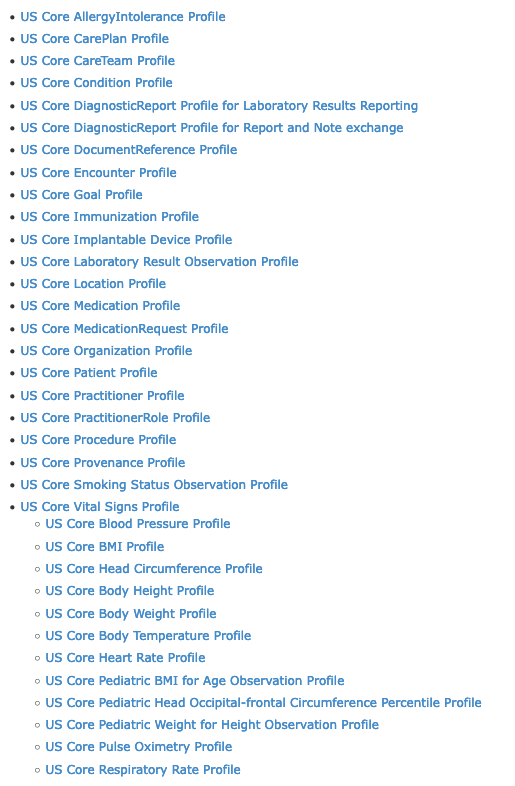

📘[Read more about FHIR Resources](https://www.hl7.org/fhir/resourcelist.html)

📘[Read more about FHIR Maturity Levels](https://www.hl7.org/fhir/versions.html#std-process)

📘[Read more about US Core](https://www.hl7.org/fhir/us/core/)

📘[Read more about USCDI](https://www.healthit.gov/isa/sites/isa/files/2020-07/USCDI-Version-1-July-2020-Errata-Final.pdf)


## FHIR Profiles and Data Types

The structure of a FHIR resource is defined by a FHIR `StructureDefinition`. Some of the key things a FHIR `StructureDefinition` defines for a resource includes:

* the elements and the data types of those elements within the FHIR resource
* the `Cardinality`, or minimum and maximum number of times the element may appear in a resource
* any terminology bindings which determine the value sets from which an coded element is expected or required to be from

Profiles within Implementation Guides build off the `StructureDefinitions` within the base FHIR specification to further constrain requirements or add expectations around extensions to support additional information not covered by the base resource profile.

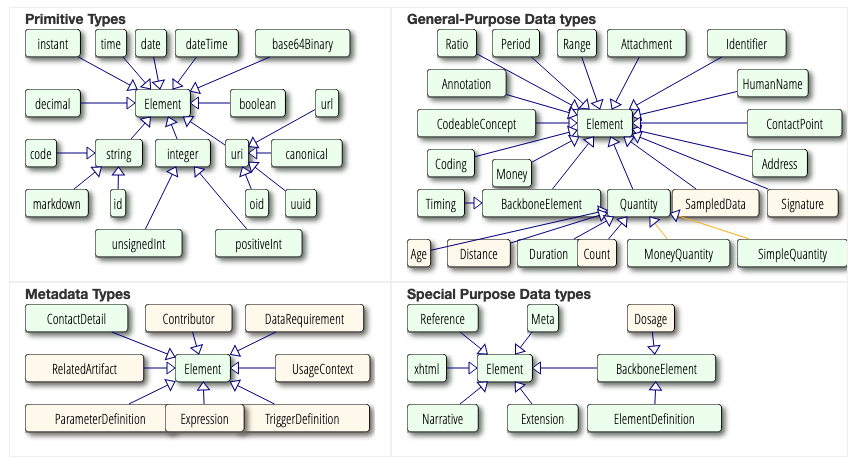

📘[Read more about StructureDefinitions](http://www.hl7.org/fhir/structuredefinition.html)

📘[Read more about Data Types](https://www.hl7.org/fhir/datatypes.html)

📘[Read more about Cardinality](https://www.hl7.org/fhir/conformance-rules.html#cardinality)

📘[Read more about Terminology Bindings](https://www.hl7.org/fhir/terminologies.html)

### Querying the Server

The FHIR Spec has a nice summary cheat sheet which is helpful for crafting queries and understanding the resources they return.

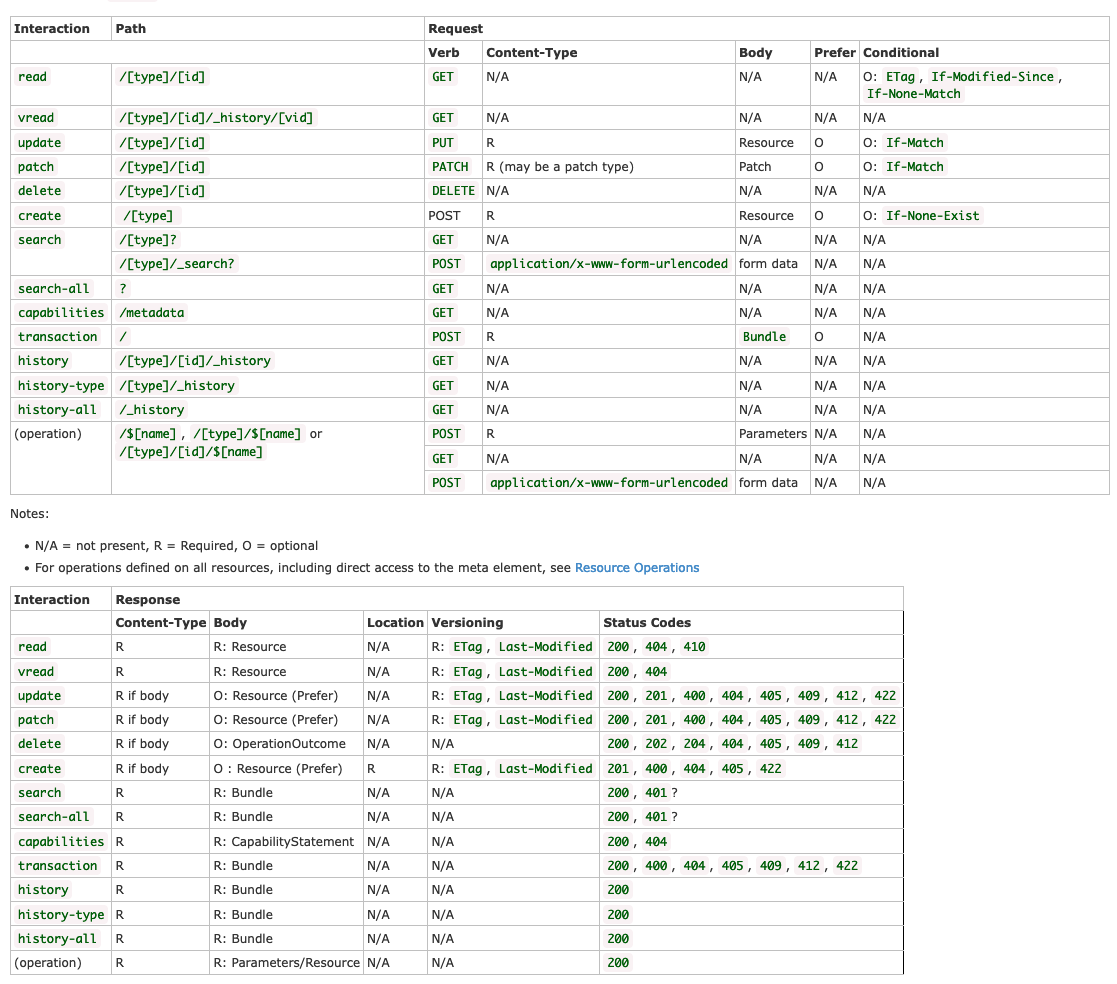

https://www.hl7.org/fhir/http.html#summary

Now that we know a little bit about the server, let's query for all the patients.

In [5]:
r = s.get(f"{FHIR_SERVER}/Patient")
patient_bundle = r.json()

print(f"Resource Type: {patient_bundle['resourceType']}")
print(f"Bundle Type: {patient_bundle['type']}")

# Create list of just the Patient Resources in the Bundle
patients = [entry['resource'] for entry in patient_bundle['entry']]

Resource Type: Bundle
Bundle Type: searchset


Servers may paginate results when there are too many matches to reasonably return in a single request. Clients can provide a `_count` which suggests to the server how many resources to return in a Bundle. Servers are required to never provide more resources in a single bundle than a client requests with `_count`, but may provide less.

📘[Read more about the FHIR pagination](http://www.hl7.org/fhir/http.html#paging)

📘[Read more about `_count`](https://www.hl7.org/fhir/STU3/search.html#count)

In [6]:
print(f"Number of matches: {patient_bundle['total']}")
print(f"Number of Patients included in Bundle: {len(patient_bundle['entry'])}")

Number of matches: 95
Number of Patients included in Bundle: 50


In this case, there are 95 total patients but only 50 were returned in the bundle.

In [7]:
next_patient_page_url = next(filter(lambda link: link['relation'] == 'next', patient_bundle['link']), None)['url']
print(next_patient_page_url)

https://api.logicahealth.org/opioids/open?_getpages=3bdb3ecc-ec80-4ddb-9cf4-405484e6adca&_getpagesoffset=50&_count=50&_pretty=true&_bundletype=searchset


In [8]:
r = s.get(next_patient_page_url)
patient_bundle_2 = r.json()
print(f"Number of Patients included in Bundle: {len(patient_bundle_2['entry'])}")

Number of Patients included in Bundle: 45


In [9]:
has_another_page = True if next(filter(lambda link: link['relation'] == 'next', patient_bundle_2['link']), None) else False
print(has_another_page)

False


Looks like we have all the search results now. We'll package up the pagination code into a method to help automate this process in future requests.

This method recursively checks for, dereferences, and appends subsequent bundles in the feed to a list.

In [10]:
# Resolves all pages for the bundle. Returns an array with all Bundles, including the original Bundle.
def resolve_pages(bundle):
    next_page_link = next(filter(lambda link: link['relation'] == 'next', bundle['link']), None)
    if next_page_link:
        next_page = s.get(next_page_link['url']).json()
        return [bundle] + resolve_pages(next_page)
    else:
        return [bundle]

# NOTE: No cell output.

Now that we can get all the patients, let's grab all the Patients out of the all the Bundles and prepare to do some analysis.

In [11]:
patient_bundles = resolve_pages(patient_bundle)

patients = [entry['resource'] for bundle in patient_bundles for entry in bundle['entry']]
print(f"Total Patient Resources: {len(patients)}")

Total Patient Resources: 95


In [12]:
patients_df = pd.DataFrame(patients)
patients_df.head()

,resourceType,id,meta,text,extension,identifier,name,telecom,gender,birthDate,address,maritalStatus,multipleBirthBoolean,communication,multipleBirthInteger
0,Patient,3437,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Heidenreich818...","[{'system': 'phone', 'value': '555-435-7289', ...",female,1996-02-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
1,Patient,4085,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Konopelski743'...","[{'system': 'phone', 'value': '555-830-4368', ...",female,1997-07-02,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
2,Patient,5072,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Eichmann909', ...","[{'system': 'phone', 'value': '555-956-1828', ...",female,1982-09-19,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
3,Patient,5871,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Kreiger457', '...","[{'system': 'phone', 'value': '555-292-5254', ...",male,1984-12-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
4,Patient,6557,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Rowe323', 'giv...","[{'system': 'phone', 'value': '555-529-4121', ...",female,1998-06-29,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN


Pandas gives us some tools to generate some general descriptive statistics based on this DataFrame

📘[Read more about `pandas.DataFrame.describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)

In [13]:
patients_df.describe(include='all')

,resourceType,id,meta,text,extension,identifier,name,telecom,gender,birthDate,address,maritalStatus,multipleBirthBoolean,communication,multipleBirthInteger
count,95,95,95,95,95,95,95,95,95,95,95,95,93,95,2.0
unique,1,95,95,95,95,95,95,95,2,95,95,3,1,4,NaN
top,Patient,3437,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Heidenreich818...","[{'system': 'phone', 'value': '555-435-7289', ...",male,1996-02-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
freq,95,1,1,1,1,1,1,1,52,1,1,45,93,88,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


# FHIR Resources and Data Frames

Panda DataFrames are 2-dimensional data structures suited for tabular data. FHIR Resources vary widely and are deeply nested and although pandas does have functionality to normalize semi-structured data into a flat table, it's not well suited to nested arrays within a FHIR Resource.

There are numerous approaches to loading FHIR into DataFrames and the approach, or combination of approaches, taken may be driven by the use case.

In the beginning of the notebook when we were dealing with the CapabilityStatement, we did some data crunching up front before loading anything into a DataFrame to only keep the data we cared about. That worked well in our scenario since we only cared about a few deeply nested fields as part of our analysis which resulted in a smaller DataFrame that was easier to manage. Some of the fields appeared as array values in the table since they were simple enough to exploded into the views we cared about, but we could have further normalized the table into rows manually if we wished.

The `patients_df` above has minimal processing applied and loads the patients directly into a DataFrame. This works well for top-level primitive FHIR elements in the resource (like `gender` and `birthDate`), but isn't optimal for complex elements, like `maritalStatus`, or arrays of elements, like `identifier`.

Below we can see that pandas built in `json_normalize` method can help some with complex elements and breaks up fields like `maritalStatus` into its individual elements, while still keeping a single row per patient. If we only cared about `maritalStatus.text` for our analysis this could be a nice approach compared to writing list comprehensions or lambdas to retrieve these elements, whether before or after the data is turned into a DataFrame. Note that the arrays of elements, including `maritalStatus.coding` and `identifier`, still aren't exploded out in these views.

As expected, there are many ways to process FHIR data and in these exercises we'll focus more on how to find the data you need in FHIR over how the data is processed.

📘[Read more about `pandas.json_normalize`](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html)

📘[Read more about `Pandas DataFrames`](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html#dataframe)

In [14]:
patients_jn = pd.json_normalize(patients, max_level=10)
patients_jn.head()

,resourceType,id,extension,identifier,name,telecom,gender,birthDate,address,multipleBirthBoolean,communication,meta.versionId,meta.lastUpdated,meta.source,meta.profile,text.status,text.div,maritalStatus.coding,maritalStatus.text,multipleBirthInteger
0,Patient,3437,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Heidenreich818...","[{'system': 'phone', 'value': '555-435-7289', ...",female,1996-02-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:30:21.000+00:00,#mUW5Jy6Tl3uauUnB,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,Never Married,NaN
1,Patient,4085,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Konopelski743'...","[{'system': 'phone', 'value': '555-830-4368', ...",female,1997-07-02,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:37:18.000+00:00,#yTw02TRSmhZHShp5,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,Never Married,NaN
2,Patient,5072,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Eichmann909', ...","[{'system': 'phone', 'value': '555-956-1828', ...",female,1982-09-19,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:40:43.000+00:00,#yPKbh9jQquRHQmE7,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,M,NaN
3,Patient,5871,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Kreiger457', '...","[{'system': 'phone', 'value': '555-292-5254', ...",male,1984-12-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:43:46.000+00:00,#iPi8Jpw3DEDTG7KX,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,M,NaN
4,Patient,6557,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Rowe323', 'giv...","[{'system': 'phone', 'value': '555-529-4121', ...",female,1998-06-29,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:46:51.000+00:00,#gaWF7ivOUHNBkp1R,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,Never Married,NaN


Arrays of complex elements can still be broken out into their own DataFrames by other means, including by applying a custom function to extract the desired elements.

In [15]:
identifiers_table = patients_df.groupby('id').identifier.apply(lambda x: pd.DataFrame(x.values[0])).reset_index()
identifiers_table.head()

,id,level_1,system,value,type
0,10098,0,https://github.com/synthetichealth/synthea,2417861b-0aeb-6be0-7ee4-8d4da85dd96f,NaN
1,10098,1,http://hospital.smarthealthit.org,2417861b-0aeb-6be0-7ee4-8d4da85dd96f,{'coding': [{'system': 'http://terminology.hl7...
2,10098,2,http://hl7.org/fhir/sid/us-ssn,999-58-1613,{'coding': [{'system': 'http://terminology.hl7...
3,10098,3,urn:oid:2.16.840.1.113883.4.3.25,S99985515,{'coding': [{'system': 'http://terminology.hl7...
4,10098,4,http://standardhealthrecord.org/fhir/Structure...,X16167510X,{'coding': [{'system': 'http://terminology.hl7...


## Patient Demographics

Now that we have all our patients, let's try and analyze their demographics.

First lets find the frequency of gender values:

In [16]:
patients_df['gender'].value_counts(normalize=True) * 100

male      54.736842
female    45.263158
Name: gender, dtype: float64

Let's also look at the frequency of the marital status codes.

In [17]:
patients_df['maritalStatus'].apply(pd.Series)['coding'].apply(lambda x: x[0]['code']).value_counts(normalize=True) * 100

S    52.631579
M    47.368421
Name: coding, dtype: float64

`M` and `S` codes are a bit cryptic, so let's check them against the display text and create a cross tabulation of the factors.

📘[Read more about `pandas.crosstab`](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html)

In [18]:
pd.crosstab(patients_df['maritalStatus'].apply(pd.Series)['coding'].apply(lambda x: x[0]['code']), patients_df['maritalStatus'].apply(pd.Series)['text'])

text,M,Never Married,S
coding,,,
M,45,0,0
S,0,36,14


It looks like there may be some data quality issues with this variable - why does `maritalStatusDisplay` have both `Never Married` and `S` if those equate to the same code of `S`?

Patient age isn't directly available in the data set, but can be calculated via the patient's birthday.

<AxesSubplot:>

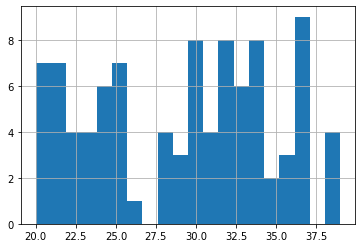

In [19]:
def age(birthday):
    birthday = datetime.strptime(birthday, "%Y-%m-%d").date()
    today = date.today()
    return today.year - birthday.year - ((today.month,today.day) < (birthday.month,birthday.day))

patients_df['birthDate'].apply(age).hist(bins=20)

# Querying for Resources

FHIR breaks up health information into chunks of data called Resources which are connected together via references.

In this use case we're interested in patients who've been prescribed opioids. Looking at the [FHIR Patient profile](https://www.hl7.org/fhir/patient.html) we see a few references to things like their primary care provider or the organization managing the patient record, but nothing about medications. Luckily, above this profile we see a list of other resources that reference Patient - including [MedicationRequest](https://www.hl7.org/fhir/medicationrequest.html#MedicationRequest). Looking within MedicationRequest we see that `MedicationRequest.subject` identifies the patient the medication is for.

Let's see if we can find the Medications prescribed to the patient with id `10098`. The core FHIR spec doesn't require that any specific searches be supported so it's important to read the documentation and look at the CapabilityStatement of the server being queried to get an idea of the options available. For now we'll look at the core FHIR spec for an idea of search parameters defined in the base spec that servers might implement.

Looking at the MedicationRequest Resource core FHIR documentation it looks like there are two search parameters that would be helpful: `patient` and `subject`. Practically either would work just fine, but looking at the Expression we can see that `patient` only works for references to a Patient resource, while `subject` would work for references to either a Patient or a Group. Looking at the CapabilityStatement, it also appears that the server supports both!

_Note: Specific FHIR Implementation Guides, like US Core, may define their own SearchParameters for servers to implement_

📘[Read more about FHIR Resource Organization](https://www.hl7.org/fhir/overview-arch.html#organizing)

In [20]:
capabilities_df[capabilities_df['Resource']=='MedicationRequest'].explode('Search')[['Resource','Search']]

,Resource,Search
78,MedicationRequest,_language
78,MedicationRequest,date
78,MedicationRequest,requester
78,MedicationRequest,identifier
78,MedicationRequest,intended-dispenser
78,MedicationRequest,authoredon
78,MedicationRequest,code
78,MedicationRequest,subject
78,MedicationRequest,medication
78,MedicationRequest,encounter


In [21]:
r = s.get(f"{FHIR_SERVER}/MedicationRequest?patient=10098")
bundle = r.json()
print(f"Total Number of MedicationRequests: {len(bundle['entry'])}")

Total Number of MedicationRequests: 25


Let's take a look at just the first to get an idea of what we're dealing with, and then check if they've been prescribed tramadol.

In [22]:
bundle['entry'][0]['resource']

{'resourceType': 'MedicationRequest',
 'id': '10389',
 'meta': {'versionId': '1',
  'lastUpdated': '2021-12-29T23:58:33.000+00:00',
  'source': '#p9JfGLVEkVh9gJXV',
  'profile': ['http://hl7.org/fhir/us/core/StructureDefinition/us-core-medicationrequest']},
 'status': 'stopped',
 'intent': 'order',
 'medicationCodeableConcept': {'coding': [{'system': 'http://www.nlm.nih.gov/research/umls/rxnorm',
    'code': '835603',
    'display': 'tramadol hydrochloride 50 MG Oral Tablet'}],
  'text': 'tramadol hydrochloride 50 MG Oral Tablet'},
 'subject': {'reference': 'Patient/10098'},
 'encounter': {'reference': 'Encounter/10371'},
 'authoredOn': '2016-04-12T20:46:17-04:00',
 'requester': {'reference': 'Practitioner/2129',
  'display': 'Dr. Jefferson174 Murphy561'},
 'dosageInstruction': [{'sequence': 1,
   'text': 'Take as needed.',
   'asNeededBoolean': True}]}

In [23]:
next(entry['resource'] for entry in bundle['entry'] if entry['resource']['medicationCodeableConcept']['coding'][0]['code'] == '835603')

{'resourceType': 'MedicationRequest',
 'id': '10389',
 'meta': {'versionId': '1',
  'lastUpdated': '2021-12-29T23:58:33.000+00:00',
  'source': '#p9JfGLVEkVh9gJXV',
  'profile': ['http://hl7.org/fhir/us/core/StructureDefinition/us-core-medicationrequest']},
 'status': 'stopped',
 'intent': 'order',
 'medicationCodeableConcept': {'coding': [{'system': 'http://www.nlm.nih.gov/research/umls/rxnorm',
    'code': '835603',
    'display': 'tramadol hydrochloride 50 MG Oral Tablet'}],
  'text': 'tramadol hydrochloride 50 MG Oral Tablet'},
 'subject': {'reference': 'Patient/10098'},
 'encounter': {'reference': 'Encounter/10371'},
 'authoredOn': '2016-04-12T20:46:17-04:00',
 'requester': {'reference': 'Practitioner/2129',
  'display': 'Dr. Jefferson174 Murphy561'},
 'dosageInstruction': [{'sequence': 1,
   'text': 'Take as needed.',
   'asNeededBoolean': True}]}

Looks like this patient has been prescribed tramadol hydrocholoride. FHIR servers can provide terminology services as well so let's `$lookup` some additional details about this code. In particular, let's check to see if the code is Inactive.

📘[Read more about FHIR Terminology](https://www.hl7.org/fhir/terminology-module.html)

📘[Read more about using RxNorm with FHIR](https://www.hl7.org/fhir/rxnorm.html)

In [24]:
r = s.get(f"http://tx.fhir.org/r4/CodeSystem/$lookup?system=http://www.nlm.nih.gov/research/umls/rxnorm&code=835603", headers={'accept': 'application/json'})
result = r.json()

In [25]:
[parameter for parameter in result['parameter'] if 'part' in parameter for part in parameter['part'] if('valueCode' in part and part['valueCode'] == 'inactive')]

[{'name': 'property',
  'part': [{'name': 'code', 'valueCode': 'inactive'},
   {'name': 'value', 'valueBoolean': False}]}]

Here we can see that the code is not inactive.

But what if we want to know something the FHIR Terminology server can't provide like the brand name for our research or a SMART-on-FHIR app used by clinicians? Let's see if the RxNorm API can help. This is where we can look to other APIs!

https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

Looks like https://lhncbc.nlm.nih.gov/RxNav/APIs/api-RxNorm.getAllRelatedInfo.html will have what we need since I know I want the [Brand Name term type](https://www.nlm.nih.gov/research/umls/rxnorm/docs/appendix5.html)

In [26]:
r = s.get(f"https://rxnav.nlm.nih.gov/REST/rxcui/835603/allrelated.json", headers={'accept': 'application/json'})
result = r.json()

print(f"Tramadol Brand Names: {', '.join([BN['name'] for conceptGroup in result['allRelatedGroup']['conceptGroup'] if conceptGroup['tty'] == 'BN' for BN in conceptGroup['conceptProperties']])}")

Tramadol Brand Names: Ultram


What if we want to know the drug schedule?

That's in the [`getAllProperties` API](https://lhncbc.nlm.nih.gov/RxNav/APIs/api-RxNorm.getAllProperties.html)

In [27]:
r = s.get(f"https://rxnav.nlm.nih.gov/REST/rxcui/835603/allProperties.json?prop=Attributes", headers={'accept': 'application/json'})
result = r.json()

print(f"Drug Schedule: {next(propConcept['propValue'] for propConcept in result['propConceptGroup']['propConcept'] if propConcept['propName'] == 'SCHEDULE')}")

Drug Schedule: 4


Looks like it's Schedule 4. It's even listed as an example on the [FDA Drug Schedule website](https://www.dea.gov/drug-information/drug-scheduling)
!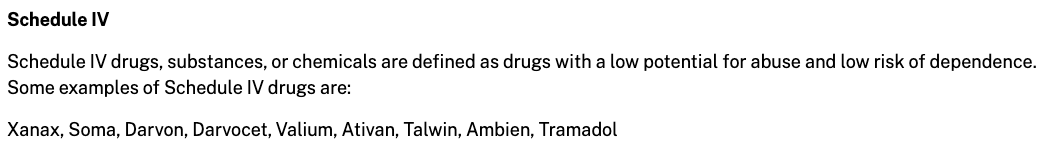


The RxNorm APIs offer a number of other helpful services which can be used to determine things like relationships to other terminology systems including `Medication Reference Terminology (MED-RT)` for determining what the drug may treat and the `Anatomical Therapeutic Chemical Classification System (ATC)` to get the class of drug.

In [28]:
#https://lhncbc.nlm.nih.gov/RxNav/APIs/api-RxClass.getClassByRxNormDrugId.html
r = s.get(f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byRxcui.json?rxcui=835603", headers={'accept': 'application/json'})
result = r.json()

# https://www.nlm.nih.gov/research/umls/sourcereleasedocs/current/MED-RT/index.html
print(f"May Treat: {next(drugInfo['rxclassMinConceptItem']['className'] for drugInfo in result['rxclassDrugInfoList']['rxclassDrugInfo'] if drugInfo['rela'] == 'may_treat')}")

May Treat: Pain


In [29]:
# https://www.nlm.nih.gov/research/umls/sourcereleasedocs/current/ATC/index.html
print(f"ATC Class: {next(drugInfo['rxclassMinConceptItem']['className'] for drugInfo in result['rxclassDrugInfoList']['rxclassDrugInfo'] if drugInfo['relaSource'] == 'ATC')}")

ATC Class: Other opioids


If we want to add the ATC class name to every medication for our patient, we can do this by defining a custom function that calls the API and extracts the first className value, and then applying this to each row in a data frame. First, let's create a data frame just for the medication codes.

In [30]:
meds_df = pd.DataFrame([entry['resource'] for entry in bundle['entry']])
med_codes_df = meds_df.groupby('id').medicationCodeableConcept.apply(lambda x: pd.DataFrame(x.values[0]['coding'])).reset_index()
med_codes_df

,id,level_1,system,code,display
0,10123,0,http://www.nlm.nih.gov/research/umls/rxnorm,749762,Seasonique 91 Day Pack
1,10280,0,http://www.nlm.nih.gov/research/umls/rxnorm,835603,tramadol hydrochloride 50 MG Oral Tablet
2,10289,0,http://www.nlm.nih.gov/research/umls/rxnorm,1860491,12 HR Hydrocodone Bitartrate 10 MG Extended Re...
3,10312,0,http://www.nlm.nih.gov/research/umls/rxnorm,835603,tramadol hydrochloride 50 MG Oral Tablet
4,10314,0,http://www.nlm.nih.gov/research/umls/rxnorm,1860491,12 HR Hydrocodone Bitartrate 10 MG Extended Re...
5,10324,0,http://www.nlm.nih.gov/research/umls/rxnorm,749762,Seasonique 91 Day Pack
6,10347,0,http://www.nlm.nih.gov/research/umls/rxnorm,835603,tramadol hydrochloride 50 MG Oral Tablet
7,10349,0,http://www.nlm.nih.gov/research/umls/rxnorm,1860491,12 HR Hydrocodone Bitartrate 10 MG Extended Re...
8,10359,0,http://www.nlm.nih.gov/research/umls/rxnorm,1000126,1 ML medroxyPROGESTERone acetate 150 MG/ML Inj...
9,10389,0,http://www.nlm.nih.gov/research/umls/rxnorm,835603,tramadol hydrochloride 50 MG Oral Tablet


Then we'll define a method for retrieving the ATC classification of an RxNorm code.

In [31]:
def get_atc_class(rxnorm):
    r = s.get(f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byRxcui.json?rxcui={rxnorm}", headers={'accept': 'application/json'})
    result = r.json()
    return next(drugInfo['rxclassMinConceptItem']['className'] for drugInfo in result['rxclassDrugInfoList']['rxclassDrugInfo'] if drugInfo['relaSource'] == 'ATC')

get_atc_class('835603')

'Other opioids'

In [32]:
med_codes_df['atc'] = med_codes_df['code'].apply(get_atc_class)
med_codes_df

,id,level_1,system,code,display,atc
0,10123,0,http://www.nlm.nih.gov/research/umls/rxnorm,749762,Seasonique 91 Day Pack,"Progestogens and estrogens, fixed combinations"
1,10280,0,http://www.nlm.nih.gov/research/umls/rxnorm,835603,tramadol hydrochloride 50 MG Oral Tablet,Other opioids
2,10289,0,http://www.nlm.nih.gov/research/umls/rxnorm,1860491,12 HR Hydrocodone Bitartrate 10 MG Extended Re...,Opium alkaloids and derivatives
3,10312,0,http://www.nlm.nih.gov/research/umls/rxnorm,835603,tramadol hydrochloride 50 MG Oral Tablet,Other opioids
4,10314,0,http://www.nlm.nih.gov/research/umls/rxnorm,1860491,12 HR Hydrocodone Bitartrate 10 MG Extended Re...,Opium alkaloids and derivatives
5,10324,0,http://www.nlm.nih.gov/research/umls/rxnorm,749762,Seasonique 91 Day Pack,"Progestogens and estrogens, fixed combinations"
6,10347,0,http://www.nlm.nih.gov/research/umls/rxnorm,835603,tramadol hydrochloride 50 MG Oral Tablet,Other opioids
7,10349,0,http://www.nlm.nih.gov/research/umls/rxnorm,1860491,12 HR Hydrocodone Bitartrate 10 MG Extended Re...,Opium alkaloids and derivatives
8,10359,0,http://www.nlm.nih.gov/research/umls/rxnorm,1000126,1 ML medroxyPROGESTERone acetate 150 MG/ML Inj...,Progestogens
9,10389,0,http://www.nlm.nih.gov/research/umls/rxnorm,835603,tramadol hydrochloride 50 MG Oral Tablet,Other opioids


In Exercise 3 we'll work more with the RxNav APIs to detect drug interactions in a patient.

There's other APIs we could use as well, including FDA APIs where we can retrieve things like adverse event reports or product labels for specific drugs.

https://open.fda.gov/apis/

In [33]:
r = s.get(f"https://api.fda.gov/drug/label.json?search=openfda.rxcui.exact=835603", headers={'accept': 'application/json'})
result = r.json()

result['results'][0]['mechanism_of_action'][0]

'12.1 Mechanism of Action Tramadol hydrochloride tablets contain tramadol, an opioid agonist and inhibitor of norepinephrine and serotonin re- uptake. Although the mode of action is not completely understood, the analgesic effect of tramadol is believed to be due to both binding to µ-opioid receptors and weak inhibition of re- uptake of norepinephrine and serotonin. Opioid activity is due to both low affinity binding of the parent compound and higher affinity binding of the O -demethylated metabolite M1 to µ-opioid receptors. In animal models, M1 is up to 6 times more potent than tramadol in producing analgesia and 200 times more potent in µ opioid binding. Tramadol-induced analgesia is only partially antagonized by the opioid antagonist naloxone in several animal tests. The relative contribution of both tramadol and M1 to human analgesia is dependent upon the plasma concentrations of each compound [see Clinical Pharmacology (12.2)] . Analgesia in humans begins approximately within one

## Learning Objectives and Key Concepts

As a recap, this this exercise you learned how to:
* Query a FHIR Server to learn about its capabilities
* How to read FHIR specifications and understand how it applies to FHIR interactions and data
* Search for resources of various types and parse the results to find information of interest
* Process paginated responses
* Understanding FHIR Resources to find data of interest
* Exploring MedicationRequest
* Integrate other, non-FHIR based APIs